# $I_{local}$ for 1D tuning 

## Setup 

setup fisher_info_limits2

In [257]:
import os
import numpy as np
from numpy import log
import matplotlib.pyplot as plt
from scipy.special import gammaln


# setup project path
main_dir = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(main_dir)

# setup pipeline parameters
SEED = 0
nxplot = 50
dx = 0.01            # smaller dx = slower but more accurate

# setup tuning curve parameters
sigmaf = np.pi / 4   # tuning curve width
f0 = 5               # baseline firing rate
A = 20               # amplitude
n_neurons = 4        # Number of neurons


## Functions

In [261]:
# utils
def sum2(data, axis=1): 
    """sum over columns (axis 1)
    while keeping data dimensionality

    Args:
        data (_type_): _description_
        axis (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    return data.sum(axis, keepdims=True)

# -------------------------------

def tuning_curve(x):
    """Wrapped Gaussian tuning curve function
    x: scalar or array of angles
    returns: array of shape (n_neurons, len(x)) firing rates
    """
    x = np.atleast_1d(x)
    
    # compute wrapped distance
    dx = np.arctan2(np.sin(x[:, None] - mu[None, :]), np.cos(x[:, None] - mu[None, :]))
    
    # Gaussian response
    return f0 + A * np.exp(-0.5 * (dx**2) / sigmaf**2)


def tuning_curve_grad(x):
    """Gradient of the tuning curve (derivative)
    x: scalar or array of angles
    returns: array of shape (len(x), n_neurons) gradients
    """
    x = np.atleast_1d(x)
    dx = np.arctan2(np.sin(x[:, None] - mu[None, :]), np.cos(x[:, None] - mu[None, :]))
    return -A * dx * np.exp(-0.5 * dx**2 / sigmaf**2) / sigmaf**2


def logsumexp(a, axis=0):
    """
    Computes log(sum(exp(a), axis)) while avoiding numerical underflow.
    Equivalent to MATLAB's logsumexp by Tom Minka.

    Parameters
    ----------
    a : np.ndarray
        Input array.
    axis : int, optional
        Axis along which to sum. Default is 0.

    Returns
    -------
    s : np.ndarray
        Log-sum-exp of the input along the specified axis.
    """
    # find the maximum along the specified axis (for numerical stability)
    a_max = np.max(a, axis=axis, keepdims=True)

    # subtract and exponentiate safely
    a_stable = a - a_max
    s = a_max + log(np.sum(np.exp(a_stable), axis=axis, keepdims=True))

    # remove the extra dimension
    s = np.squeeze(s, axis=axis)

    # handle non-finite max values (like -inf)
    return np.where(np.isfinite(a_max), s, a_max)


# unit-testing  ----------------------------------

def test_logpr_x0():
    """test logpr_x0 function
    """
    # mock inputs
    xsamp_rates = np.array([5.9539, 22.9341, 11.1758, 5.0390])[None].T
    r = np.array([[ 6],
            [26],
            [10],
            [ 1]])
    
    # compute logpr_x0
    logpr_x0 =  log(xsamp_rates.T) @ r - sum2(xsamp_rates.T) - sum(gammaln(r + 1))
    assert np.allclose(logpr_x0, -10.1409248, atol=1e-3), "wrong logpr_x0"


def test_logpr_x():
    """test logpr_x function
    """
    # mock inputs
    x = np.array([-3.1416 , -3.1316])
    r = np.array([[ 6], [26], [10], [ 1]])
    x_rates = tuning_curve(x).T
    # compute logpr_x
    logpr_x =  log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r + 1)) # OK!
    assert np.allclose(logpr_x, np.array([[-48.25999692], [-48.18853962]]), atol=1e-6), "test_logpr_x() failed"


def test_logsumexp():
    # mock inputs
    logpr_x = np.array([[-48.25999692], [-48.18853962]])

    # compte lse
    lse = logsumexp(logpr_x, 0)
    assert np.allclose(lse, np.array([[-47.53048296]]), atol=1e-6), "logsumexp failed"

## Testing

In [262]:
# run unit-tests
test_logpr_x0()
test_logpr_x()
test_logsumexp()

In [263]:
# x points to plot, from -pi to pi
xplot = np.linspace(-np.pi, np.pi, nxplot + 1)
xplot = xplot[:-1]                              # OK!

# x used to compute probability distributions
x = np.arange(-np.pi, np.pi, dx)
x = x[:-1]                                       # OK!

Text(0.5, 1.0, 'Neural Tuning Curves')

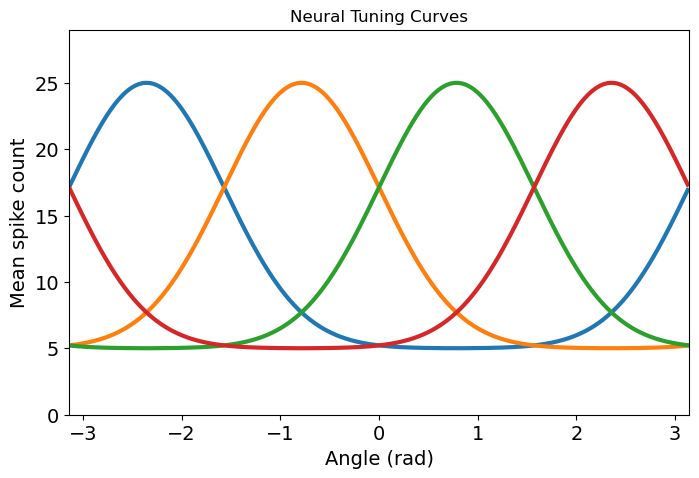

In [264]:
# position centers of tuning curves, uniformly spaced
mu = np.linspace(-np.pi, np.pi, n_neurons + 1)[:-1]
mu = mu - np.mean(mu)

# plot tuning curves
plt.figure(figsize=(8, 5))
plt.plot(x, tuning_curve(x), linewidth=3)
plt.ylabel('Mean spike count', fontsize=14)
plt.xlabel('Angle (rad)', fontsize=14)
plt.xlim([-np.pi, np.pi])
plt.ylim([0, f0 + 1.2*A])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Neural Tuning Curves')

In [ ]:
%%time 

np.random.seed(SEED)

# compute information, Inf = I(R;X) - brute force calculation
# required:

# Initialize variables
Inf = 0              # I(R;X)
nsamp = int(1e4)     # number of samples

# report
print("\nComputing I(R;X), brute force")

# average neural response to x
x_rates = tuning_curve(x).T # OK!

for i in range(nsamp):

    # sample stimulus uniformly between -pi and pi 
    # a scalar   
    xsamp = np.random.rand() * 2 * np.pi - np.pi  # OK!

    # sample response from Poisson with rate f(xsamp)
    # r is of shape (n_neurons,1)
    xsamp_rates = tuning_curve(xsamp).T     # OK!
    r = np.random.poisson(xsamp_rates)      # OK!
    
    # log p(rsamp|xsamp), a scalar
    logpr_x0 = log(xsamp_rates.T) @ r - sum2(xsamp_rates.T) - sum(gammaln(r + 1)) # OK!

    # estimate log p(rsamp)
    logpr_x = log(x_rates.T) @ r - sum2(x_rates.T) - sum(gammaln(r + 1)) # OK!

    # log(p(r))
    logpr = logsumexp(logpr_x,0) - log(len(x)) # OK!

    # mutual information (~1.87)
    Inf = Inf * (i) / (i + 1) + (logpr_x0 - logpr) / (i + 1) # OK!


Computing I(R;X), brute force
CPU times: user 520 ms, sys: 0 ns, total: 520 ms
Wall time: 519 ms


In [298]:
(logpr_x0 - logpr)

array([[2.62039178]])

In [294]:
log(len(x))

np.float64(6.4425401664681985)

In [295]:
len(x)

628

In [296]:
# test_logpr_x()
logpr_x
# np.array([[-48.25999692], [-48.18853962]])

array([[-64.70685356],
       [-64.60188529],
       [-64.49590877],
       [-64.38888896],
       [-64.28078896],
       [-64.17157   ],
       [-64.06119155],
       [-63.94961129],
       [-63.83678518],
       [-63.72266752],
       [-63.60721098],
       [-63.49036668],
       [-63.37208421],
       [-63.25231174],
       [-63.13099606],
       [-63.00808265],
       [-62.88351575],
       [-62.75723848],
       [-62.62919287],
       [-62.49931994],
       [-62.36755987],
       [-62.23385198],
       [-62.09813491],
       [-61.96034668],
       [-61.82042479],
       [-61.67830634],
       [-61.53392812],
       [-61.38722673],
       [-61.23813869],
       [-61.08660053],
       [-60.93254893],
       [-60.77592085],
       [-60.61665358],
       [-60.45468495],
       [-60.28995337],
       [-60.12239801],
       [-59.95195887],
       [-59.77857694],
       [-59.60219431],
       [-59.42275427],
       [-59.24020147],
       [-59.054482  ],
       [-58.86554353],
       [-58

In [297]:
x_rates.T

array([[17.13061319,  5.22217993,  5.22217993, 17.13061319],
       [17.28505659,  5.23081204,  5.21383599, 16.97616975],
       [17.43944953,  5.23974065,  5.20577204, 16.821776  ],
       ...,
       [16.61836199,  5.19555396,  5.25198094, 17.64285796],
       [16.77261528,  5.20326092,  5.24264833, 17.48860958],
       [16.92698285,  5.21123737,  5.23362349, 17.33424338]],
      shape=(628, 4))